In [1]:
## -- Set Device-Agnostic code --
import torch

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
else:
    pass

print(f"\nℹ️ Cuda available: {torch.cuda.is_available()}")


ℹ️ Cuda available: False


In [2]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from itertools import combinations, product
from tqdm.notebook import tqdm
from time import time, sleep

## -- MACHINE LEARNING --
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay

if torch.cuda.is_available():
    import cuml
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    from sklearn.preprocessing import TargetEncoder as sciTE

import catboost as cgb

import warnings

In [3]:
print(f"catboost version: {cgb.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"shap version: {shap.__version__}")

catboost version: 1.2.8
sklearn version: 1.7.2
shap version: 0.44.1


In [4]:
## --- GLOBAL SETTINGS --- ##
sklearn.set_config(transform_output="pandas")

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
# pd.options.mode.copy_on_write = True
# plt.style.use("whitegrid")

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [5]:
## -- Load Data --
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
            ignore_index=True)

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} has shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")

Train has shape: (517754, 13)
Test has shape: (172585, 12)
Original has shape: (112000, 13)

Total Numerical: 4
Total Categorical: 8


In [6]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [7]:
## -- Unique value counts per dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
Train,3,4,261,5,3,3,2,2,3,2,2,8
Original,3,4,101,5,3,3,2,2,3,2,2,11
Test,3,4,195,5,3,3,2,2,3,2,2,8


### FEATURE ENGINEERING

In [8]:
## -- meta feature --
for df in [train, test, orig]:
    base_risk = (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
            )
    df['meta'] = base_risk

BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
# for df in [train, test]:
#     df['BINARY'] = 0
#     for i in range(len(BINARY_COLS)):
#         df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)

FEATURES.append('meta')
print(f"✅ 'meta' feature created!")
print(f"✅ 'BINARY' feature created!")

✅ 'meta' feature created!
✅ 'BINARY' feature created!


In [9]:
## -- Generate 'base_score' predictions as feature --
# from scipy.stats import norm

# def f(X):
#     return \
#     0.3 * X["curvature"] + \
#     0.2 * (X["lighting"] == "night").astype(int) + \
#     0.1 * (X["weather"] != "clear").astype(int) + \
#     0.2 * (X["speed_limit"] >= 60).astype(int) + \
#     0.1 * (X["num_reported_accidents"] > 2).astype(int)

# def clip(f):
#     def clip_f(X):
#         sigma = 0.05
#         mu = f(X)
#         a, b = -mu/sigma, (1-mu)/sigma
#         Phi_a, Phi_b = norm.cdf(a), norm.cdf(b)
#         phi_a, phi_b = norm.pdf(a), norm.pdf(b)
#         return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
#     return clip_f

# for df in [train, test, orig]:
#     meta = clip(f)(df)
#     df["base_score"] = meta.values

# FEATURES.append("base_score")
# FEATURES

In [10]:
## -- FEATURE 1: Use original as features
FEAT = [c for c in orig.columns if c not in [TARGET]] # Exclude binned features
print(f"Merging {len(FEAT)} features: ", end="")
STATS = ['mean'] #,'count','nunique','max','min',
for c in FEAT:
    print(f"{c}, ", end="")
    tmp = orig.groupby(c)[TARGET].agg(STATS)
    tmp.columns = [f'OTE_{c}_{s.upper()}' for s in STATS]
    train = train.merge(tmp, on=c, how='left')
    test  = test.merge(tmp, on=c, how='left')

print()

Merging 13 features: road_type, num_lanes, curvature, speed_limit, lighting, weather, road_signs_present, public_road, time_of_day, holiday, school_season, num_reported_accidents, meta, 


In [11]:
## -- Factorize using combined data --
for c in CATS:
    combined = pd.concat([train[c], test[c]], axis=0)
    combined = combined.factorize()[0]
    train[c] = combined[:len(train)]
    test[c]  = combined[len(train):]

print(f"✅ Label encoding for {len(CATS)} features.")

✅ Label encoding for 8 features.


In [12]:
BINS = []
print(f"\nCreating bins... ", end="")
for c in ['curvature', 'meta']: # <- add feature 1 after the other
    for b in [10]:
        print(f"{c}_{b}, ", end="")
        b_n = f'{c}_b{b}'
        # Fit on train data and transform both train and test
        bins = np.linspace(train[c].min(), train[c].max(), b+1)
        train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
        test[b_n] = pd.cut(test[c], include_lowest=True, labels=False, bins=bins)
        BINS.append(b_n)
print()
print(f"✅ {len(BINS)} binned features created!")


Creating bins... curvature_10, meta_10, 
✅ 2 binned features created!


In [13]:
# ## -- Pairwise combinations --
# # MASTER_COLS = ['curvature', 'meta']
# SLAVE_COLS  = [x for x in FEATURES if x not in ['curvature', 'meta']]
# master_slave_pairs = list(product(BINS, SLAVE_COLS))

# TE1 = []
# for c in tqdm(master_slave_pairs, desc="Creating Master-Slave Pairwise"):
#     # The order of the columns in 'c' is (master, slave)
#     c1 = c[0] # Master Column
#     c2 = c[1] # Slave Column
#     n = f'TE1_{c1}-|-{c2}'
#     train[n] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n]  = test[c1].astype(str)  + '_' + test[c2].astype(str)
#     train[n] = train[n].astype('category')
#     cat = train[n].cat
#     train[n] = train[n].cat.codes
#     test[n]  = pd.Categorical(test[n], categories=cat.categories).codes
#     TE1.append(n)

# print(f"✅ TE1 features: {len(TE1)}")

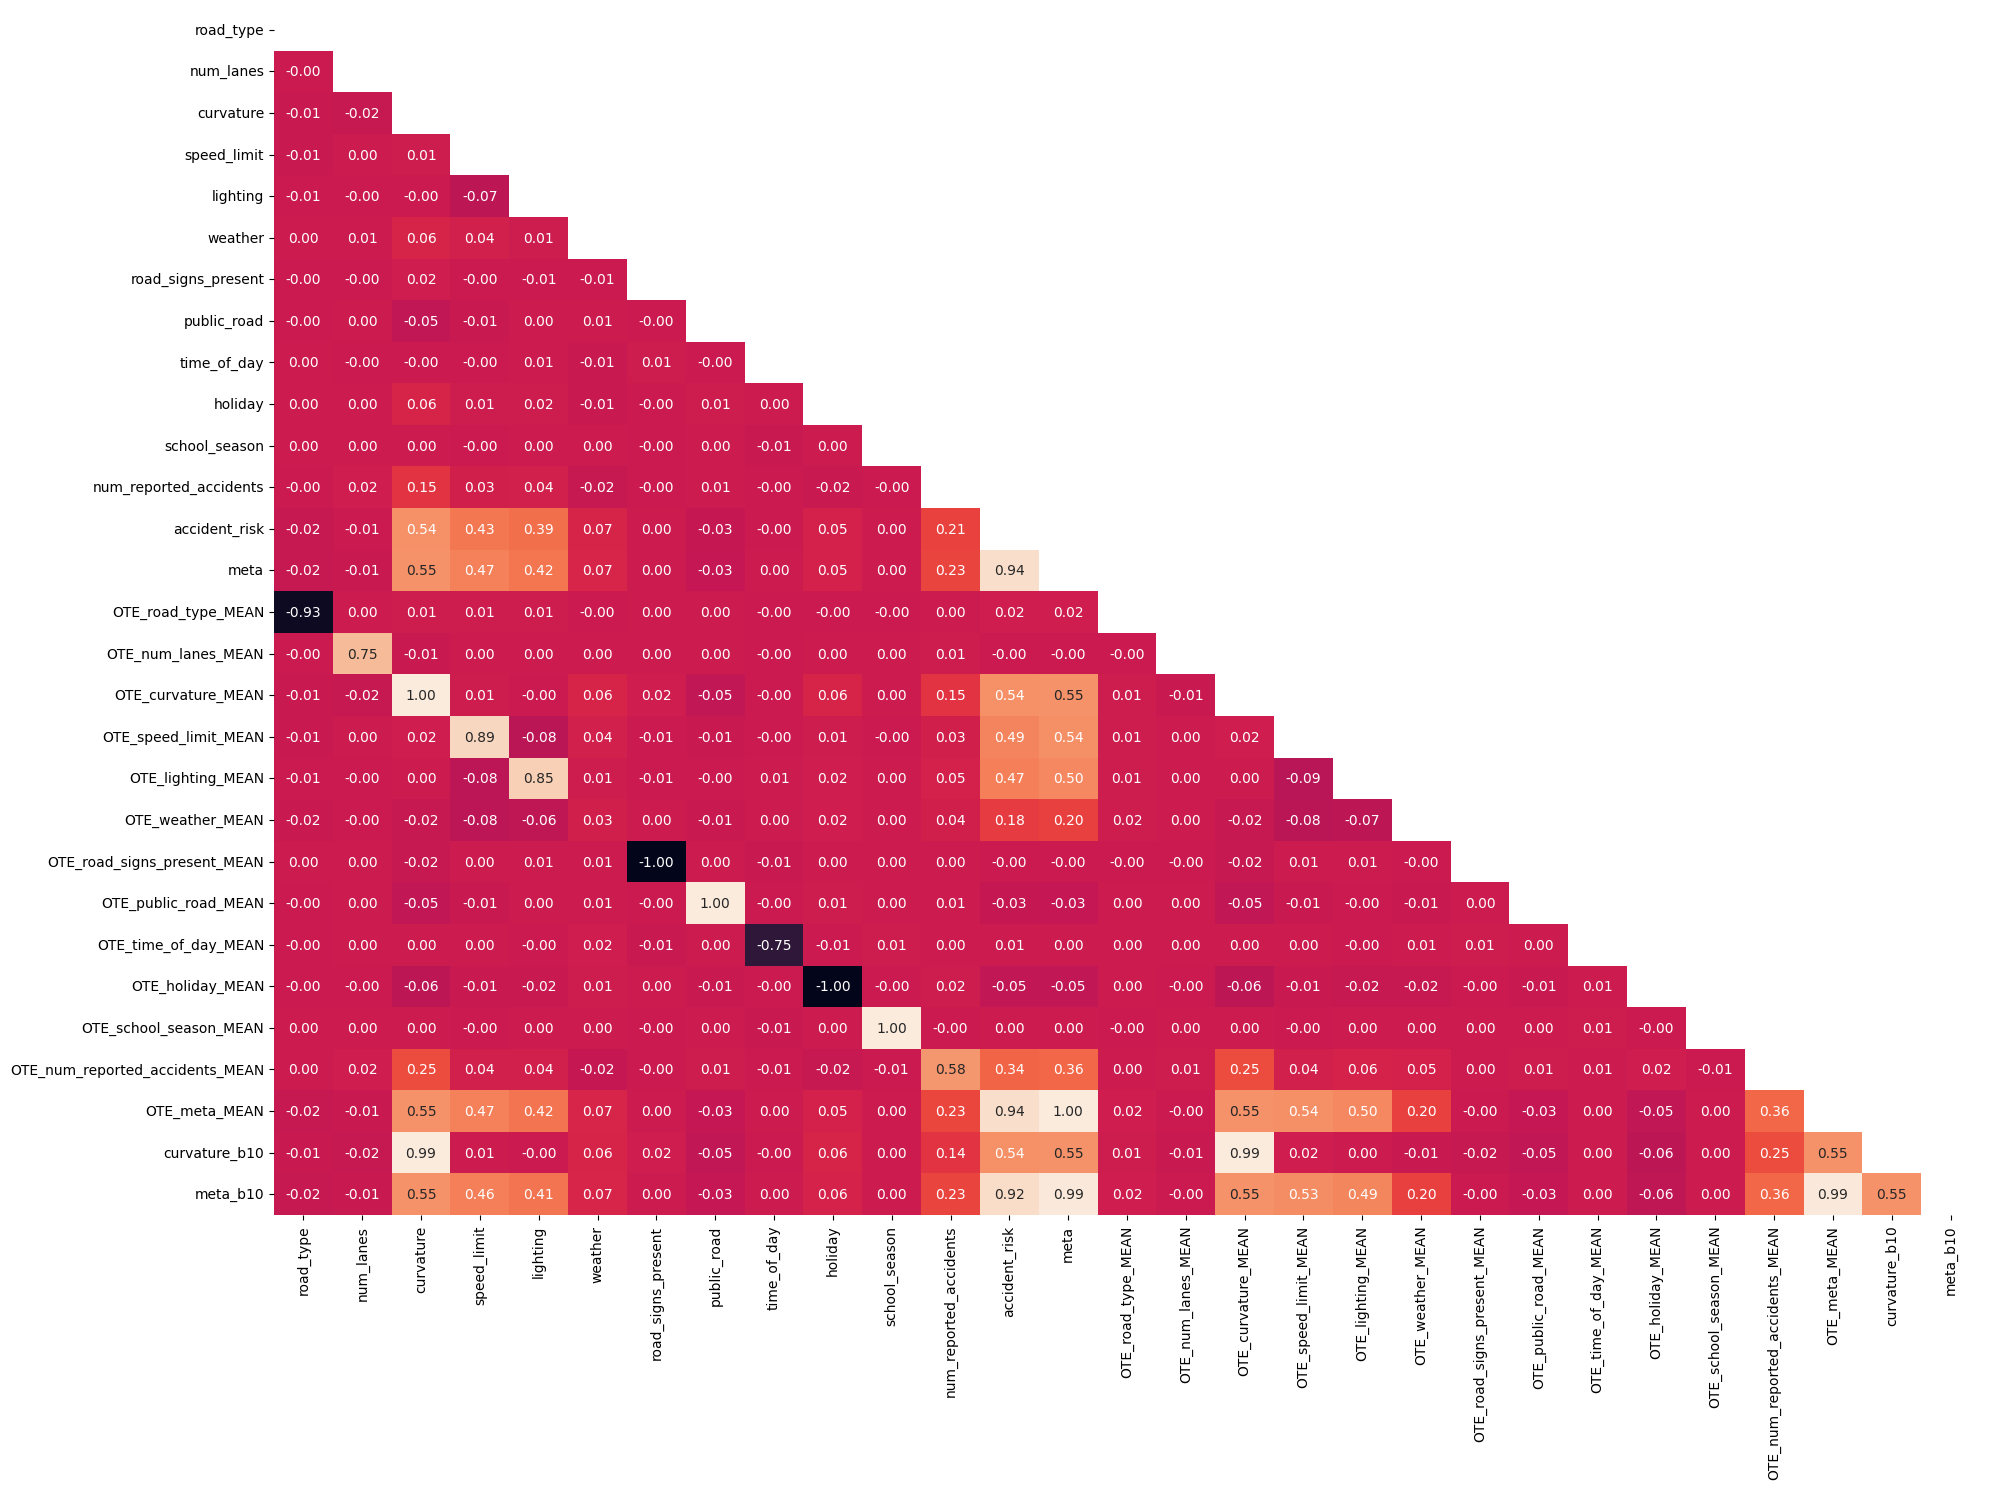

In [14]:
## -- Heatmap Plot --
plt.figure(figsize=(20, 15))
sns.heatmap(train.corr(), mask=np.triu(train.corr()), annot=True, fmt='.2f', cbar=False)
plt.tight_layout()
plt.show()

In [15]:
# -- Pairwise combinations --
TE2 = []
# COLS = [c for c in FEATURES if c not in BINARY_COLS]
for c in tqdm(list(combinations(FEATURES+BINS, 2)), desc="Creating Pairwise"):
    n = f'TE2_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + train[c[1]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + test[c[1]].astype(str)
    
    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n]  = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE2.append(n)

Creating Pairwise:   0%|          | 0/105 [00:00<?, ?it/s]

In [16]:
## -- Triplewise combinations --
TOP_PREDICTORS = ['meta','curvature','lighting','speed_limit','weather','num_reported_accidents']
TE3 = []
for c in tqdm(list(combinations(TOP_PREDICTORS, 3)), desc="Creating Triplewise"):
    n = f'TE3_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + \
               train[c[1]].astype(str) + '_' + \
               train[c[2]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + \
               test[c[1]].astype(str) + '_' + \
               test[c[2]].astype(str)

    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n] = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE3.append(n)

Creating Triplewise:   0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
len(TE2), len(TE3)

(105, 20)

In [18]:
__ = [c for c in train.columns if train[c].nunique() < 2]
print(f"Produced {len(__)} single value features: {__}")
train = train.drop(__, axis=1)
test = test.drop(__, axis=1)
print(f"Drop {len(__)} columns... Complete!")

Produced 0 single value features: []
Drop 0 columns... Complete!


In [19]:
display(train.head())
# display(train.info())
train.shape, test.shape

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,OTE_road_type_MEAN,OTE_num_lanes_MEAN,OTE_curvature_MEAN,OTE_speed_limit_MEAN,OTE_lighting_MEAN,OTE_weather_MEAN,OTE_road_signs_present_MEAN,OTE_public_road_MEAN,OTE_time_of_day_MEAN,OTE_holiday_MEAN,OTE_school_season_MEAN,OTE_num_reported_accidents_MEAN,OTE_meta_MEAN,curvature_b10,meta_b10,TE2_num_lanes-|-curvature,TE2_num_lanes-|-speed_limit,TE2_num_lanes-|-num_reported_accidents,TE2_num_lanes-|-road_type,TE2_num_lanes-|-lighting,TE2_num_lanes-|-weather,TE2_num_lanes-|-road_signs_present,TE2_num_lanes-|-public_road,TE2_num_lanes-|-time_of_day,TE2_num_lanes-|-holiday,TE2_num_lanes-|-school_season,TE2_num_lanes-|-meta,TE2_num_lanes-|-curvature_b10,TE2_num_lanes-|-meta_b10,TE2_curvature-|-speed_limit,TE2_curvature-|-num_reported_accidents,TE2_curvature-|-road_type,TE2_curvature-|-lighting,TE2_curvature-|-weather,TE2_curvature-|-road_signs_present,TE2_curvature-|-public_road,TE2_curvature-|-time_of_day,TE2_curvature-|-holiday,TE2_curvature-|-school_season,TE2_curvature-|-meta,TE2_curvature-|-curvature_b10,TE2_curvature-|-meta_b10,TE2_speed_limit-|-num_reported_accidents,TE2_speed_limit-|-road_type,TE2_speed_limit-|-lighting,TE2_speed_limit-|-weather,TE2_speed_limit-|-road_signs_present,TE2_speed_limit-|-public_road,TE2_speed_limit-|-time_of_day,TE2_speed_limit-|-holiday,TE2_speed_limit-|-school_season,TE2_speed_limit-|-meta,TE2_speed_limit-|-curvature_b10,TE2_speed_limit-|-meta_b10,TE2_num_reported_accidents-|-road_type,TE2_num_reported_accidents-|-lighting,TE2_num_reported_accidents-|-weather,TE2_num_reported_accidents-|-road_signs_present,TE2_num_reported_accidents-|-public_road,TE2_num_reported_accidents-|-time_of_day,TE2_num_reported_accidents-|-holiday,TE2_num_reported_accidents-|-school_season,TE2_num_reported_accidents-|-meta,TE2_num_reported_accidents-|-curvature_b10,TE2_num_reported_accidents-|-meta_b10,TE2_road_type-|-lighting,TE2_road_type-|-weather,TE2_road_type-|-road_signs_present,TE2_road_type-|-public_road,TE2_road_type-|-time_of_day,TE2_road_type-|-holiday,TE2_road_type-|-school_season,TE2_road_type-|-meta,TE2_road_type-|-curvature_b10,TE2_road_type-|-meta_b10,TE2_lighting-|-weather,TE2_lighting-|-road_signs_present,TE2_lighting-|-public_road,TE2_lighting-|-time_of_day,TE2_lighting-|-holiday,TE2_lighting-|-school_season,TE2_lighting-|-meta,TE2_lighting-|-curvature_b10,TE2_lighting-|-meta_b10,TE2_weather-|-road_signs_present,TE2_weather-|-public_road,TE2_weather-|-time_of_day,TE2_weather-|-holiday,TE2_weather-|-school_season,TE2_weather-|-meta,TE2_weather-|-curvature_b10,TE2_weather-|-meta_b10,TE2_road_signs_present-|-public_road,TE2_road_signs_present-|-time_of_day,TE2_road_signs_present-|-holiday,TE2_road_signs_present-|-school_season,TE2_road_signs_present-|-meta,TE2_road_signs_present-|-curvature_b10,TE2_road_signs_present-|-meta_b10,TE2_public_road-|-time_of_day,TE2_public_road-|-holiday,TE2_public_road-|-school_season,TE2_public_road-|-meta,TE2_public_road-|-curvature_b10,TE2_public_road-|-meta_b10,TE2_time_of_day-|-holiday,TE2_time_of_day-|-school_season,TE2_time_of_day-|-meta,TE2_time_of_day-|-curvature_b10,TE2_time_of_day-|-meta_b10,TE2_holiday-|-school_season,TE2_holiday-|-meta,TE2_holiday-|-curvature_b10,TE2_holiday-|-meta_b10,TE2_school_season-|-meta,TE2_school_season-|-curvature_b10,TE2_school_season-|-meta_b10,TE2_meta-|-curvature_b10,TE2_meta-|-meta_b10,TE2_curvature_b10-|-meta_b10,TE3_meta-|-curvature-|-lighting,TE3_meta-|-curvature-|-speed_limit,TE3_meta-|-curvature-|-weather,TE3_meta-|-curvature-|-num_reported_accidents,TE3_meta-|-lighting-|-speed_limit,TE3_meta-|-lighting-|-weather,TE3_meta-|-lighting-|-num_reported_accidents,TE3_meta-|-speed_limit-|-weather,TE3_meta-|-speed_limit-|-num_reported_accidents,TE3_meta-|-weather-|-num_reported_accidents,TE3_curvature-|-lighting-|-speed_limit,TE3_curvature-|-lighting-|-weather,TE3_curva

((517754, 154), (172585, 153))

### MODEL TRAINING

In [20]:
## -- DEFINE TRAINING PARAMETERS --
# params = dict(
#     grow_policy = "SymmetricTree",
#     bootstrap_type = "Bayesian",
#     bagging_temperature = 0.3,
#     eta = 0.005,
#     depth = 7,
#     l2_leaf_reg = 0.05,
#     allow_writing_files = False,
#     loss_function = "RMSE",
#     eval_metric = "RMSE", 
#     task_type = "CPU",
# )

params = dict(
    grow_policy = 'Depthwise',
    bootstrap_type ='MVS',
    min_data_in_leaf = 30,
    subsample = 0.85,
    # colsample_bynode = 0.5,
    eta = 0.008,
    depth = 6,
    l2_leaf_reg = 0.005,
    allow_writing_files=False,
    loss_function = "RMSE",
    eval_metric = "RMSE",
    task_type = 'CPU',
)

# params = dict(
#     grow_policy = 'Lossguide',
#     bootstrap_type ='Bernoulli',
#     min_data_in_leaf = 40,
#     subsample = 0.85,
#     colsample_bynode = 0.5,
#     max_leaves = 70,
#     eta = 0.008,
#     depth = 7,
#     l2_leaf_reg = 0.005,
#     allow_writing_files = False,
#     loss_function = "RMSE",
#     eval_metric = "RMSE",
#     task_type = 'CPU',
# )

ℹ️ Device: CPU 4 cores
|---------------------------------
	Fold 1 #####


Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

0:	learn: 0.1652879	test: 0.1650038	best: 0.1650038 (0)	total: 669ms	remaining: 9h 17m 15s
200:	learn: 0.0646684	test: 0.0641189	best: 0.0641189 (200)	total: 1m 52s	remaining: 7h 43m 39s
400:	learn: 0.0565635	test: 0.0564164	best: 0.0564164 (400)	total: 3m 37s	remaining: 7h 29m 3s
600:	learn: 0.0560363	test: 0.0560480	best: 0.0560480 (600)	total: 5m 16s	remaining: 7h 13m 21s
800:	learn: 0.0559053	test: 0.0559940	best: 0.0559940 (800)	total: 6m 49s	remaining: 6h 58m 43s
1000:	learn: 0.0558274	test: 0.0559633	best: 0.0559633 (1000)	total: 8m 11s	remaining: 6h 40m 43s
1200:	learn: 0.0557655	test: 0.0559421	best: 0.0559421 (1199)	total: 9m 33s	remaining: 6h 28m 4s
1400:	learn: 0.0557091	test: 0.0559262	best: 0.0559262 (1399)	total: 10m 52s	remaining: 6h 17m 23s
1600:	learn: 0.0556545	test: 0.0559126	best: 0.0559126 (1600)	total: 12m 9s	remaining: 6h 7m 34s
1800:	learn: 0.0555989	test: 0.0559018	best: 0.0559018 (1800)	total: 13m 21s	remaining: 5h 57m 37s
2000:	learn: 0.0555450	test: 0.05589

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

0:	learn: 0.1653266	test: 0.1647613	best: 0.1647613 (0)	total: 594ms	remaining: 8h 15m 5s
200:	learn: 0.0645869	test: 0.0646255	best: 0.0646255 (200)	total: 1m 54s	remaining: 7h 51m 15s
400:	learn: 0.0564624	test: 0.0569970	best: 0.0569970 (400)	total: 3m 40s	remaining: 7h 35m 16s
600:	learn: 0.0559342	test: 0.0566217	best: 0.0566217 (600)	total: 5m 20s	remaining: 7h 19m 1s
800:	learn: 0.0558012	test: 0.0565660	best: 0.0565660 (800)	total: 6m 52s	remaining: 7h 2m 36s
1000:	learn: 0.0557203	test: 0.0565366	best: 0.0565366 (1000)	total: 8m 16s	remaining: 6h 44m 55s
1200:	learn: 0.0556566	test: 0.0565150	best: 0.0565150 (1200)	total: 9m 35s	remaining: 6h 29m 52s
1400:	learn: 0.0555992	test: 0.0564986	best: 0.0564986 (1398)	total: 10m 52s	remaining: 6h 17m
1600:	learn: 0.0555436	test: 0.0564849	best: 0.0564849 (1599)	total: 12m 6s	remaining: 6h 6m 10s
1800:	learn: 0.0554822	test: 0.0564752	best: 0.0564752 (1800)	total: 13m 13s	remaining: 5h 54m 2s
2000:	learn: 0.0554210	test: 0.0564675	bes

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

0:	learn: 0.1651632	test: 0.1657490	best: 0.1657490 (0)	total: 614ms	remaining: 8h 32m 4s
200:	learn: 0.0646728	test: 0.0641412	best: 0.0641412 (200)	total: 1m 53s	remaining: 7h 49m 52s
400:	learn: 0.0565726	test: 0.0562978	best: 0.0562978 (400)	total: 3m 41s	remaining: 7h 35m 49s
600:	learn: 0.0560435	test: 0.0559197	best: 0.0559197 (600)	total: 5m 21s	remaining: 7h 20m 38s
800:	learn: 0.0559063	test: 0.0558674	best: 0.0558674 (800)	total: 6m 55s	remaining: 7h 5m 30s
1000:	learn: 0.0558298	test: 0.0558445	best: 0.0558445 (1000)	total: 8m 18s	remaining: 6h 46m 25s
1200:	learn: 0.0557667	test: 0.0558283	best: 0.0558283 (1200)	total: 9m 40s	remaining: 6h 33m 26s
1400:	learn: 0.0557074	test: 0.0558165	best: 0.0558165 (1400)	total: 10m 59s	remaining: 6h 21m 29s
1600:	learn: 0.0556513	test: 0.0558075	best: 0.0558075 (1600)	total: 12m 14s	remaining: 6h 10m 13s
1800:	learn: 0.0555958	test: 0.0558018	best: 0.0558016 (1787)	total: 13m 25s	remaining: 5h 59m 4s
2000:	learn: 0.0555452	test: 0.0557

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

0:	learn: 0.1651943	test: 0.1655605	best: 0.1655605 (0)	total: 561ms	remaining: 7h 47m 7s
200:	learn: 0.0646353	test: 0.0644531	best: 0.0644531 (200)	total: 1m 53s	remaining: 7h 49m 46s
400:	learn: 0.0565279	test: 0.0566884	best: 0.0566884 (400)	total: 3m 40s	remaining: 7h 35m 2s
600:	learn: 0.0559905	test: 0.0563000	best: 0.0563000 (600)	total: 5m 22s	remaining: 7h 21m 30s
800:	learn: 0.0558557	test: 0.0562446	best: 0.0562446 (800)	total: 6m 55s	remaining: 7h 5m 34s
1000:	learn: 0.0557759	test: 0.0562170	best: 0.0562170 (1000)	total: 8m 17s	remaining: 6h 46m 14s
1200:	learn: 0.0557101	test: 0.0561954	best: 0.0561954 (1200)	total: 9m 37s	remaining: 6h 30m 55s
1400:	learn: 0.0556495	test: 0.0561799	best: 0.0561799 (1400)	total: 10m 57s	remaining: 6h 19m 57s
1600:	learn: 0.0555948	test: 0.0561682	best: 0.0561681 (1599)	total: 12m 10s	remaining: 6h 8m 1s
1800:	learn: 0.0555353	test: 0.0561614	best: 0.0561611 (1789)	total: 13m 23s	remaining: 5h 58m 14s
2000:	learn: 0.0554824	test: 0.056156

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

0:	learn: 0.1652850	test: 0.1650411	best: 0.1650411 (0)	total: 541ms	remaining: 7h 30m 42s
200:	learn: 0.0646618	test: 0.0641860	best: 0.0641860 (200)	total: 1m 56s	remaining: 7h 59m 34s
400:	learn: 0.0565693	test: 0.0564779	best: 0.0564779 (400)	total: 3m 44s	remaining: 7h 43m 8s
600:	learn: 0.0560430	test: 0.0561117	best: 0.0561117 (600)	total: 5m 24s	remaining: 7h 24m 45s
800:	learn: 0.0559109	test: 0.0560653	best: 0.0560653 (800)	total: 6m 57s	remaining: 7h 7m 21s
1000:	learn: 0.0558283	test: 0.0560419	best: 0.0560419 (1000)	total: 8m 21s	remaining: 6h 49m 4s
1200:	learn: 0.0557667	test: 0.0560268	best: 0.0560268 (1200)	total: 9m 40s	remaining: 6h 33m 15s
1400:	learn: 0.0557100	test: 0.0560152	best: 0.0560151 (1399)	total: 11m 2s	remaining: 6h 22m 49s
1600:	learn: 0.0556541	test: 0.0560080	best: 0.0560080 (1600)	total: 12m 17s	remaining: 6h 11m 20s
1800:	learn: 0.0555963	test: 0.0560012	best: 0.0560012 (1799)	total: 13m 28s	remaining: 6h 49s
2000:	learn: 0.0555362	test: 0.0559949	b

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

0:	learn: 0.1651987	test: 0.1655458	best: 0.1655458 (0)	total: 539ms	remaining: 7h 29m 18s
200:	learn: 0.0646464	test: 0.0642730	best: 0.0642730 (200)	total: 1m 55s	remaining: 7h 54m 58s
400:	learn: 0.0565535	test: 0.0564950	best: 0.0564950 (400)	total: 3m 55s	remaining: 8h 5m 31s
600:	learn: 0.0560272	test: 0.0561147	best: 0.0561147 (600)	total: 5m 37s	remaining: 7h 42m 19s
800:	learn: 0.0558956	test: 0.0560601	best: 0.0560601 (800)	total: 7m 15s	remaining: 7h 25m 25s
1000:	learn: 0.0558183	test: 0.0560321	best: 0.0560321 (1000)	total: 8m 39s	remaining: 7h 3m 52s
1200:	learn: 0.0557509	test: 0.0560116	best: 0.0560116 (1200)	total: 10m 6s	remaining: 6h 50m 26s
1400:	learn: 0.0556912	test: 0.0559955	best: 0.0559955 (1400)	total: 11m 25s	remaining: 6h 36m 20s
1600:	learn: 0.0556323	test: 0.0559807	best: 0.0559807 (1600)	total: 12m 49s	remaining: 6h 27m 33s
1800:	learn: 0.0555654	test: 0.0559712	best: 0.0559710 (1799)	total: 14m 1s	remaining: 6h 15m 33s
2000:	learn: 0.0554983	test: 0.0559

Target Encoding:   0%|          | 0/125 [00:00<?, ?it/s]

0:	learn: 0.1652869	test: 0.1650310	best: 0.1650310 (0)	total: 643ms	remaining: 8h 55m 25s
200:	learn: 0.0646753	test: 0.0640374	best: 0.0640374 (200)	total: 1m 58s	remaining: 8h 10m 15s
400:	learn: 0.0565662	test: 0.0563127	best: 0.0563127 (400)	total: 3m 47s	remaining: 7h 49m 56s
600:	learn: 0.0560340	test: 0.0559462	best: 0.0559462 (600)	total: 5m 29s	remaining: 7h 31m 10s
800:	learn: 0.0559020	test: 0.0558954	best: 0.0558954 (800)	total: 7m 3s	remaining: 7h 13m 12s
1000:	learn: 0.0558233	test: 0.0558673	best: 0.0558673 (1000)	total: 8m 25s	remaining: 6h 52m 5s
1200:	learn: 0.0557598	test: 0.0558481	best: 0.0558481 (1200)	total: 9m 43s	remaining: 6h 34m 59s
1400:	learn: 0.0557024	test: 0.0558327	best: 0.0558327 (1400)	total: 10m 59s	remaining: 6h 21m 15s
1600:	learn: 0.0556445	test: 0.0558208	best: 0.0558207 (1599)	total: 12m 15s	remaining: 6h 10m 34s
1800:	learn: 0.0555849	test: 0.0558114	best: 0.0558114 (1799)	total: 13m 22s	remaining: 5h 58m 7s
2000:	learn: 0.0555208	test: 0.0558

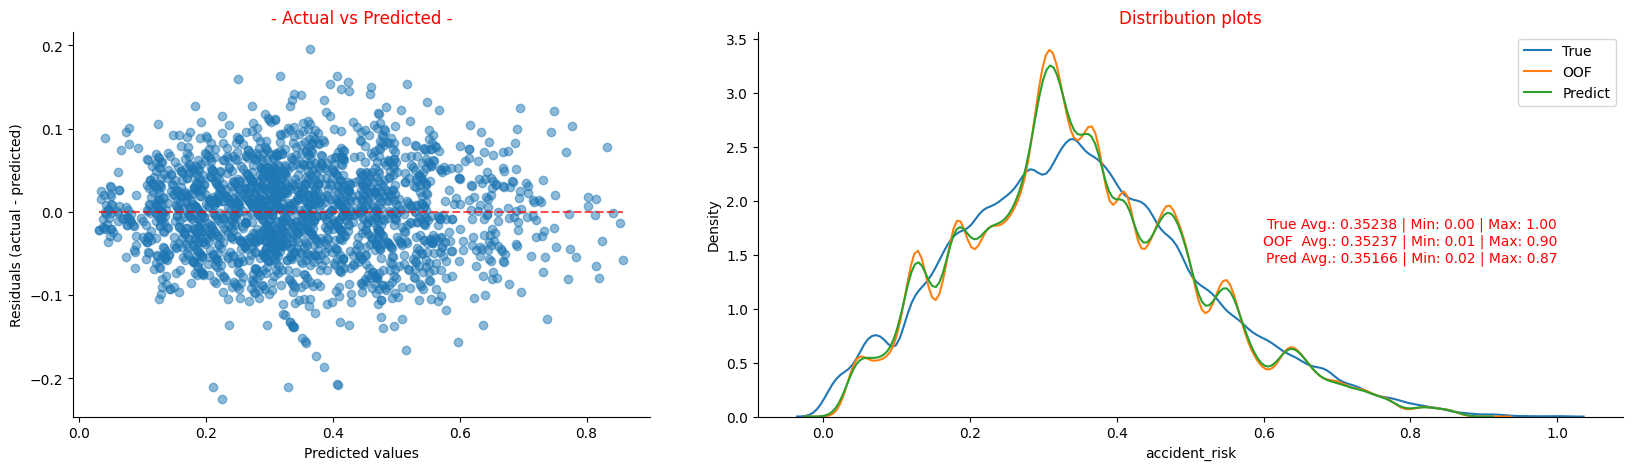

Training Time: 194.60 mins =========================


In [21]:
## -- DEFINE TRAINING PARAMETERS --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## ----------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

## -- Initiate Training -- ##
oof_preds   = np.zeros(len(train))
test_preds  = np.zeros(len(test))
fold_scores = []

X = train.drop(TARGET, axis=1)
y = train[TARGET]

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
rand_seeds = np.ceil(np.linspace(0, 39, FOLDS)).astype(int)

tik = time()
for fold, (t_idx, v_idx) in enumerate(kf.split(X)):
    print(f"|{'-'*33}")
    print(f"\t{COLOR}Fold {fold+1} {'#'*5}{RESET}")

    X_train, X_val = X.iloc[t_idx], X.iloc[v_idx]
    y_train, y_val = y.iloc[t_idx], y.iloc[v_idx]

    X_train_enc = X_train.copy()
    X_val_enc   = X_val.copy()
    test_enc    = test.copy()

    ## -- Target Encoding --
    for col in tqdm(TE2+TE3, desc="Target Encoding", leave=False):
        if torch.cuda.is_available(): # -> GPU
            TE_enc = cuTE(n_folds=5, smooth=0.1, split_method='random')
        else: # -> CPU
            TE_enc = sciTE(cv=5, smooth=10, random_state=SEED)
            
        X_train_enc[col] = TE_enc.fit_transform(X_train_enc[[col]], y_train).astype('float32')
        X_val_enc[col]   = TE_enc.transform(X_val_enc[[col]]).astype('float32')
        test_enc[col]    = TE_enc.transform(test_enc[[col]]).astype('float32')

    X_train_enc[CATS] = X_train_enc[CATS].astype("category")
    X_val_enc[CATS]   = X_val_enc[CATS].astype("category")
    test_enc[CATS]    = test_enc[CATS].astype("category")

    ## -- Create Pool objects --
    dtrain = cgb.Pool(data=X_train_enc, label=y_train, cat_features=CATS)
    dval   = cgb.Pool(data=X_val_enc, label=y_val, cat_features=CATS)
    dtest  = cgb.Pool(data=test_enc, cat_features=CATS)

    params['random_seed'] = rand_seeds[fold]
    model = cgb.train(
                    dtrain=dtrain,
                    params=params,
                    num_boost_round=50_000,
                    eval_set=dval,
                    # metric_period=3,
                    early_stopping_rounds=300,
                    verbose=200,
    )
    y_pred = model.predict(dval)
    oof_preds[v_idx] = np.clip(y_pred, 0, 1)
    predictions = model.predict(dtest)
    test_preds += np.clip(predictions, 0, 1) / FOLDS

    ## -- Compute RMSE for validation fold --
    fold_rmse = rmse(y_val, y_pred)
    fold_scores.append(fold_rmse)
    print(f"\t{COLOR}RMSE Score: {fold_rmse:.6f}{RESET}")

    sleep(2); gc.collect(); sleep(2) # Rest. Clean. Repeat.

## -- After all folds --
overall_score = rmse(y, oof_preds)
print(f"|{'-'*50}{COLOR}")
print(f"| Total No.features: {len(X_train_enc.columns)}")
print(f"| Overall OOF  RMSE: {overall_score:.6f}")
print(f"| Average Fold RMSE: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}{RESET}")

## -- Plot predictions errors --
GRID_ = dict(width_ratios=[0.4, 0.6], wspace=0.15)
fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw=GRID_)
display = PredictionErrorDisplay.from_predictions(
                y, oof_preds, ax=axs[0], subsample=2000,
                # kind = "actual_vs_predicted",
                scatter_kwargs={"alpha": 0.5}, line_kwargs={'color': 'r'},
        )
axs[0].set_title(f"- Actual vs Predicted -", color='r')
LABELS = ['True', 'OOF', 'Predict']
sns.kdeplot(y, ax=axs[1], label=LABELS[0])
sns.kdeplot(oof_preds, ax=axs[1], label=LABELS[1])
sns.kdeplot(test_preds, ax=axs[1], label=LABELS[2])
axs[1].set_title(f"Distribution plots", color='r')
TEXT = f"""
True Avg.: {np.mean(y):.5f} | Min: {np.min(y):.2f} | Max: {np.max(y):.2f}
OOF  Avg.: {np.mean(oof_preds):.5f} | Min: {np.min(oof_preds):.2f} | Max: {np.max(oof_preds):.2f}
Pred Avg.: {np.mean(test_preds):.5f} | Min: {np.min(test_preds):.2f} | Max: {np.max(test_preds):.2f}
        """
axs[1].text(x=1, y=2, s=TEXT, ha='right', va='top', color='r')

for ax in axs:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()

name = f"catMVS_" + f"{overall_score:.6f}".split('.')[1]
oof_final  = pd.DataFrame(oof_preds, columns=[name])
test_final = pd.DataFrame(test_preds, columns=[name])

tok = time()
tiktok = (tok-tik) / 60
print(f"Training Time: {tiktok:.2f} mins {'='*25}")

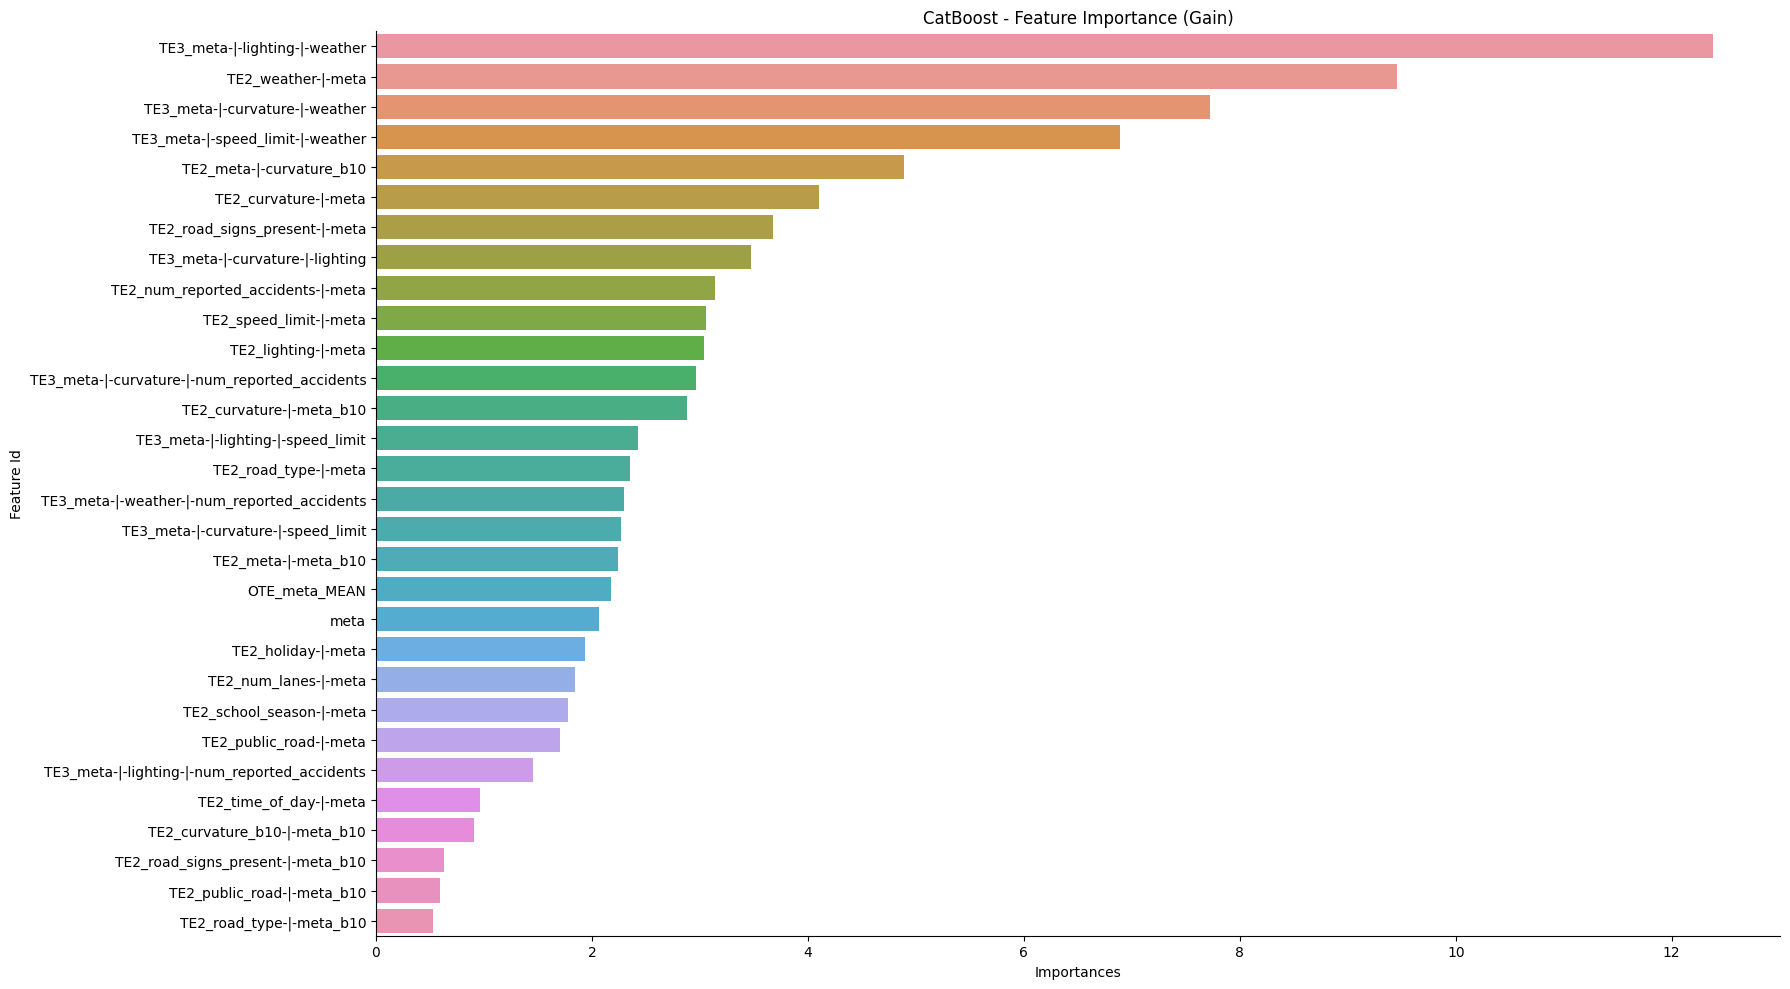

In [22]:
## -- Plot Feature Importances --
MAX = 30
feature_importances = model.get_feature_importance(prettified=True)

plt.figure(figsize=(18, 10))
ax = sns.barplot(x='Importances', y='Feature Id', data=feature_importances.head(MAX))
ax.set_title("CatBoost - Feature Importance (Gain)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [23]:
## -- Save OOF & PREDICTIONS --
oof_final.to_parquet(f"{name}_oof.parquet", index=False)
test_final.to_parquet(f"{name}_pred.parquet", index=False)

## -- Submission file --
submit[TARGET] = test_final.values
submit.to_csv(f"submit_{name}.csv", index=False)
submit.head()

,id,accident_risk
0,517754,0.293282
1,517755,0.119156
2,517756,0.176824
3,517757,0.314904
4,517758,0.400736


In [24]:
# @title
# ## -- GPU FORWARD FEATURE SELECTION -- ##
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# ADD  = []
# best_rmse = 0
# best_oof = None
# best_pred = None

# FOLDS = 5
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# X = train.drop(TARGET, axis=1)
# y = train[TARGET]

# # FORWARD FEATURE SELECTION
# for k, col in enumerate(['baseline']+TE_columns, start=1):
#     oof_cuRF = np.zeros(len(X))
#     pred_cuRF = np.zeros(len(test))
#     # scaler = RobustScaler()
#     encoder = ce.TargetEncoder(cols=col, smoothing=10)

#     if col != 'baseline': ADD.append(col)

#     # K-FOLD USING YEAR AS GROUP
#     for i, (train_index, test_index) in enumerate(kf.split(X)):
#         # TRAIN AND VALID DATA
#         x_train = X.loc[train_index, ['TrackDurationMs']+ADD].copy()
#         y_train = y.loc[train_index]
#         x_valid = X.loc[test_index, ['TrackDurationMs']+ADD].copy()
#         y_valid = y.loc[test_index]
#         x_test = test[['TrackDurationMs']+ADD].copy()

#         # x_train = scaler.fit_transform(x_train)
#         # x_valid = scaler.transform(x_valid)

#         if col != 'baseline':
#             encoder.fit(x_train, y_train)
#             x_train = encoder.transform(x_train)
#             x_valid = encoder.transform(x_valid)

#         # # SVC WANTS STANDARIZED FEATURES
#         # for c in ORIG_FEATURES+ADD:
#         #     m = x_train[c].mean()
#         #     s = x_train[c].std()
#         #     x_train[c] = (x_train[c]#-m)/s
#         #     x_valid[c] = (x_valid[c]#-m)/s
#         #     x_test[c] = (x_test[c]#-m)/s
#         #     x_test[c] = x_test[c]#.fillna(0)

#         # TRAIN SVC MODEL
#         # model = RandomForestClassifier()
#         model = xgb.XGBRegressor(random_state=SEED, device=USE_cud, n_estimators=200)
#         model.fit(x_train.values, y_train.values)

#         # INFER OOF
#         oof_cuRF[test_index] = model.predict(x_valid.values)
#         # INFER TEST
#         pred_cuRF += model.predict(x_test.values)

#     gc.collect()

#     # COMPUTE AVERAGE TEST PREDS
#     pred_cuRF /= FOLDS

#     # COMPUTE CV VALIDATION AUC SCORE
#     # true = y.values
#     m = rmse(y.values, oof_cuRF)

#     if m<best_rmse:
#         print(f"{k}. \033[32m ❇️ NEW_ BEST with {col} at {m:.6f}{RESET}")
#         best_auc = m
#         best_oof = oof_cuRF.copy()
#         best_pred = pred_cuRF.copy()
#     else:
#         print(f"{k}. \033[31m 🔻 NEW_WORSE with {col} at {m:.6f}{RESET}")
#         ADD.remove(col)